# 2024 Exercise 9: Kernels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons


## Exercise 1: Kernel Ridge Regression

1. Consider an artificial dataset with random input points $X$ uniformly-distributed in the range $[−4, +4]$
and ground-truth function $f^*(X) = \sin(X) + 2 \cos(4X) + 10 \sin(X + 1)$. We are going to try to learn
this dataset from the observations $y(X) = f^∗(X) + \eta$, with $\eta \sim N(0, 1)$. Plot $n = 50$ training points
with their labels.

(50,)
(100, 1)
(100,)


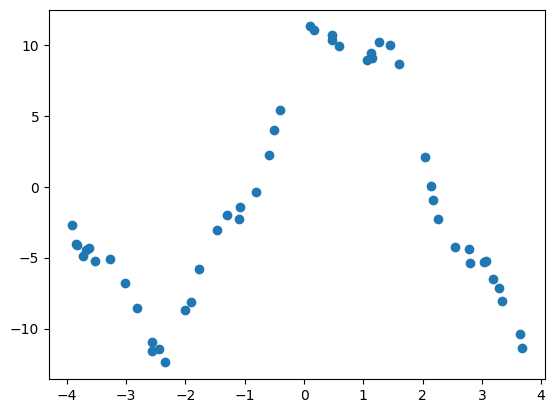

In [2]:
n = 50
X_train = np.random.rand(n, 1) * 8 - 4

# Data for sklearn methods should be of the shape (n_samples, n_features).
# Thus, in 1d, (n_samples, 1)

def ground_truth(x):
    y = np.sin(x) + 2 * np.cos(4 * x) + 10 * np.sin(x + 1)
    return y.squeeze()

# Labels, instead, should be of shape (n_samples,).
# array.squeeze() removes all array's dimensions of length 1.

y_train = ground_truth(X_train) + np.random.rand(n)
X_test = np.linspace(-4, 4, 100).reshape(-1, 1)
y_test = ground_truth(X_test)

print(y_train.shape);print(X_test.shape);print(y_test.shape)

plt.scatter(X_train,y_train);plt.show()


2. Try to learn this function using `sklearn.kernel_ridge.KernelRidge` (https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) with a linear "kernel", and regularization strength $\alpha = 0.01$. Plot the predictor on the test set and compare with the ground truth.
Comment.

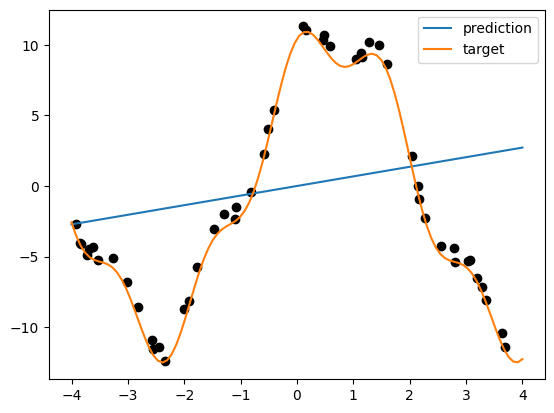

In [3]:
# "Kernel" ridge regression with the linear kernel
krr = KernelRidge(alpha=0.1, kernel='linear')
krr.fit(X_train, y_train)
y_test_pred = krr.predict(X_test)

# Plot the training set, the predictor, and the ground truth

plt.scatter(X_train, y_train, color='k')
plt.plot(X_test, y_test_pred, label='prediction')
plt.plot(X_test, y_test, label='target')
plt.legend()


3. Repeat substituting the linear kernel with the RBF kernel (*do not use metrics.pairwise.rbf_kernel as it was indicated before, just pass 'rbf' as an argument as shown in the KernelRidge documentation*).

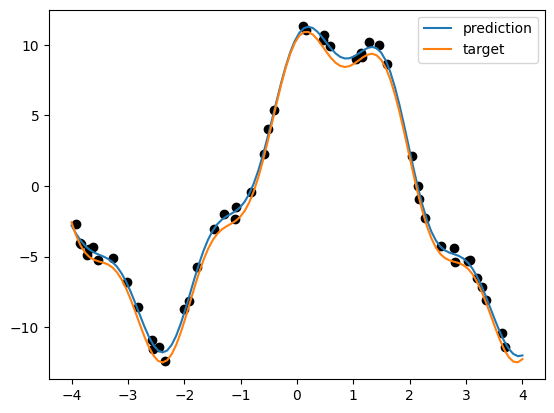

In [4]:
# Kernel ridge regression with the RBF kernel
krr = KernelRidge(alpha=0.01, kernel='rbf')
krr.fit(X_train, y_train)
y_test_pred = krr.predict(X_test)
plt.scatter(X_train, y_train, color='k')
plt.plot(X_test, y_test_pred, label='prediction')
plt.plot(X_test, y_test, label='target')
plt.legend();plt.show()


## Exercise 2: Kernelized Logistic Regression

What about classification? Previously, in the class, we have seen that a linear model for classification is logistic regression, which solves the following optimization problem $$\min_w \sum_{i=1}^n \log (1 + \exp (-y_i(X_i \cdot w))).$$ Can we use it with kernels to classify non-linearly-separable data? The answer is yes, by mapping the data in the feature space, i.e., $X_i \to \phi(X_i)$, and applying the representer theorem, i.e., $w = \sum_{j=1}^n \alpha_j \phi(X_j)$, we obtain
$$\min_\alpha \sum_{i=1}^n \log \left(1 + \exp \left(-y_i \left(\phi(X_i)\sum_{j=1}^n \alpha_j \phi(X_j)\right)\right)\right),$$
$$\min_\alpha \sum_{i=1}^n \log \left(1 + \exp \left(-y_i \left(\sum_{j=1}^n \alpha_j K(X_i, X_j)\right)\right)\right).$$
Therefore, it is sufficient to substitute the data matrix $X$ with the kernel matrix $K_{ij} = K(X_i, X_j)$ in the sklearn algorithm!

1. Using `sklearn.linear_model.LogisticRegression` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), fit the two-moons dataset with the RBF kernel and predict the value of the model on the test points. You can use `metrics.pairwise.rbf_kernel` to compute the kernel and pass the kernel bandwidth $\gamma=10$ as an argument. Use the code in the notebook to plot the training points and the decision boundary.


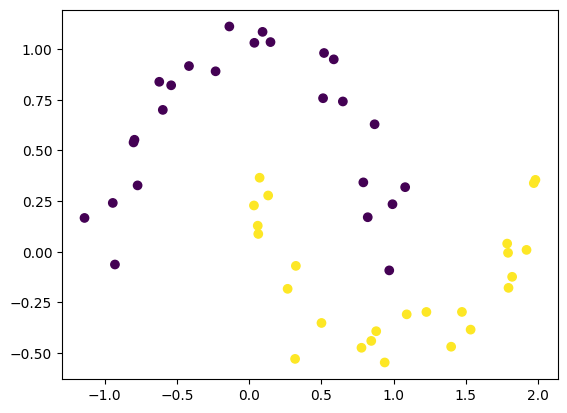

In [5]:
X_train, y_train = make_moons(n_samples=50, noise=0.1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);plt.show()


In [6]:
def test_meshgrid(X_train):
    '''
    This function returns an array of test points X_test and their coordinates
    on a meshgrid (x_mesh, y_mesh). numpy.meshgrid creates coordinate values to
    construct a 2d grid. We will pass the output X_test to the kernel and use
    x_mesh, y_mesh to plot the decision boundary with matplotlib's plt.contourf.
    '''

    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    x_mesh, y_mesh = np.meshgrid(
        np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    X_test = np.c_[x_mesh.ravel(), y_mesh.ravel()] # Concatenation along second axis.

    return X_test, x_mesh, y_mesh


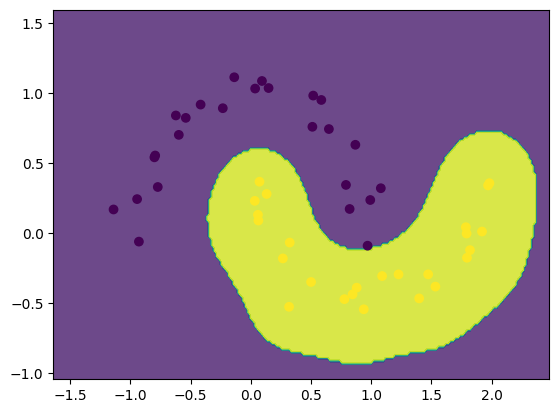

In [7]:
# Kernelized Logistic regression with the RBF kernel
gamma = 10
K_trtr = metrics.pairwise.rbf_kernel(X_train, X_train, gamma=gamma)
klr = LogisticRegression()
klr.fit(K_trtr, y_train)

X_test, x_mesh, y_mesh = test_meshgrid(X_train)

K_tetr = metrics.pairwise.rbf_kernel(X_test, X_train, gamma=gamma)
y_pred = klr.predict(K_tetr)
y_pred = y_pred.reshape(x_mesh.shape)
plt.contourf(x_mesh, y_mesh, y_pred, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);plt.show()


2. Repeat with the Laplacian kernel (`metrics.pairwise.laplacian_kernel`). How do the decision boundaries learned with the two kernels differ? Why?

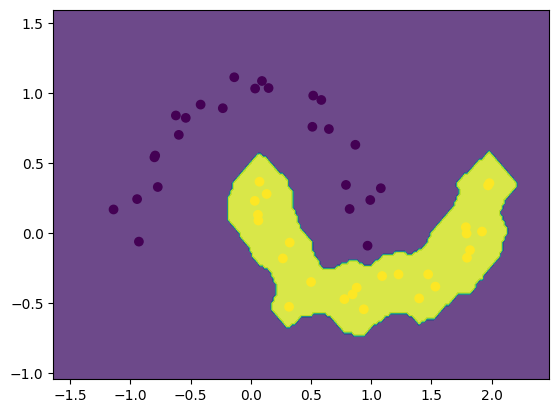

In [8]:
# Kernelized Logistic regression with the Laplacian kernel

gamma = 10
K_trtr = metrics.pairwise.laplacian_kernel(X_train, X_train, gamma=gamma)
klr = LogisticRegression()
klr.fit(K_trtr, y_train)

X_test, x_mesh, y_mesh = test_meshgrid(X_train,)

K_tetr = metrics.pairwise.laplacian_kernel(X_test, X_train, gamma=gamma)
y_pred = klr.predict(K_tetr)
y_pred = y_pred.reshape(x_mesh.shape)
plt.contourf(x_mesh, y_mesh, y_pred, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);plt.show()

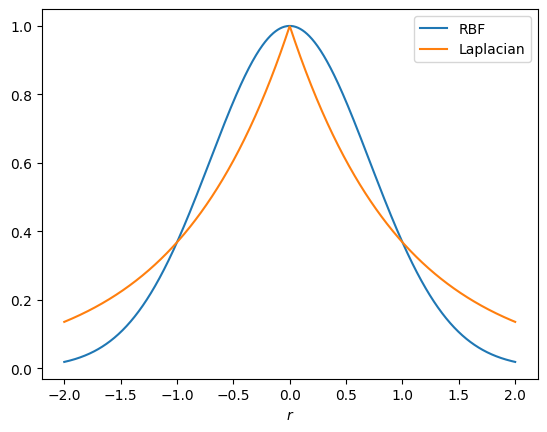

In [9]:
r = np.linspace(-2,2,1000)
gamma = 1
plt.plot(r, np.exp(- gamma * r**2), label="RBF")
plt.plot(r, np.exp(- gamma * np.abs(r)), label="Laplacian")
plt.xlabel("$r$")
plt.legend();plt.show()


## Exercise 3: Predicting Atomization Energies with Kernels

Predicting ground-state molecular properties is a critical task in chemistry. However, solving the Schrodinger equation is computationally intractable even for small systems. Instead, in this homework, you will use a machine learning approach. In particular, you will predict the atomization energies of small organic molecules using kernels. You will use a subset of the QM7 dataset. Each molecule in this dataset is represented by an $N \times N$ *Coulomb matrix* $M$, where $N$ is the number of atoms in the largest molecule.  The matrix $M$ is specified by the set of nuclear coordinates $\{R_i\}_{i\leq N}$ and the corresponding charges $\{Z_i\}_{i \leq N}$,
\begin{equation}
    M_{ij} = \frac{1}{2} \, Z_i^{2.4 }\, \delta_{ij} + \frac{Z_i Z_j}{\|R_i-R_j\|} \, (1 - \delta_{ij}).
\end{equation}
If a molecule has less than $N$ atoms, the remaining elements of $M$ are set to 0.
Notice that the off-diagonal elements correspond to the Coulomb repulsion between different atoms in the molecule, which gives the name to this molecular representation.

 1. The dataset is stored as a dictionary-like object in the file `molecules_dataset.npz` and is already divided into train, validation, and test sets, with keys `X_train`, `y_train`, `X_val`, `y_val`, and `X_test`, `y_test` respectively. The numpy arrays $X$'s contain the upper triangular parts of the normalized Coulomb matrices, and the numpy arrays $y$'s the atomization energies of the molecules in units of kcal/mol. Open the dataset using `numpy.load`.
 ```
 dataset = numpy.load('molecules_dataset.pt')
 X_train = dataset['X_train']
 ...
 ```

In [11]:
dataset = np.load('molecules_dataset.npz')
X_train, y_train = dataset['X_train'], dataset['y_train']
X_val, y_val = dataset['X_val'], dataset['y_val']
X_test, y_test = dataset['X_test'], dataset['y_test']


 2. Do kernel ridge regression with the Laplacian kernel (https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html). Set the regularization $\alpha=10^{-8}$ and select the scale parameter $\gamma\in\{10^{-6},10^{-5},10^{-4},10^{-3},10^{-2},10^{-1}\}$ resulting in the best Mean Squared Error on the validation set.

In [12]:
def MSE(f, y):
    return ((f - y)**2).mean()

for gamma in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:

    krr = KernelRidge(alpha=1e-8, kernel='laplacian', gamma=gamma)
    krr.fit(X_train, y_train)
    y_val_pred = krr.predict(X_val)

    print(f'gamma: {gamma}, \t validation mse: {MSE(y_val_pred, y_val):.2f}')


gamma: 1e-06, 	 validation mse: 50.19
gamma: 1e-05, 	 validation mse: 50.23
gamma: 0.0001, 	 validation mse: 49.01
gamma: 0.001, 	 validation mse: 45.13
gamma: 0.01, 	 validation mse: 58.81
gamma: 0.1, 	 validation mse: 10844.30


 3. For the selected value of $\gamma$, plot your predictions on the test set vs the true test labels and compute the root mean square error in kcal/mol.


test rmse: 7.37 kcal/mol


Text(0, 0.5, 'predicted energies')

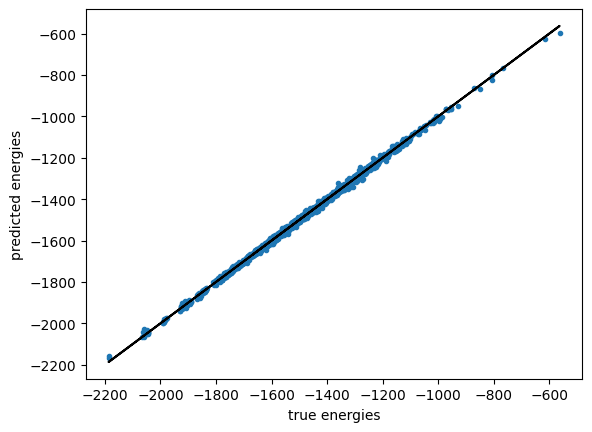

In [13]:
gamma = 1e-3
krr = KernelRidge(alpha=1e-8, kernel='laplacian', gamma=gamma)
krr.fit(X_train, y_train)
y_test_pred = krr.predict(X_test)

print(f'test rmse: {MSE(y_test_pred, y_test)**.5:.2f} kcal/mol')

plt.plot(y_test, y_test_pred, '.')
plt.plot(y_test, y_test, 'k')
plt.xlabel('true energies')
plt.ylabel('predicted energies')